In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import  tqdm
from scipy.stats import pearsonr
pd.set_option('display.max_columns',None)

In [2]:
df_list = pd.read_excel('hs300.xls', sheet_name=None, header=0)
df = pd.concat(df_list.values(), ignore_index=True).dropna().reset_index(drop=True)
df_list = []
df.columns=['id','name','date','open','close','high','low','return','return_percent','pre_close','vwap','volume','value','turnover']
df.replace('--',0,inplace=True)

In [3]:
df_sh300 = pd.read_excel('000300.xls').dropna()
df_sh300.columns=['id','name','date','open','close','high','low','return','return_percent','pre_close']
df_sh300.set_index('date',drop=True,inplace=True)

In [4]:
new_df = df.pivot(index='date', columns='id', values='return_percent').fillna(0)

In [5]:
df_sh300.head()

,id,name,open,close,high,low,return,return_percent,pre_close
date,,,,,,,,,
2018-11-12,000300.SH,沪深300,3160.246,3205.1407,3206.512,3152.439,37.6965,1.1901,3167.4442
2018-11-13,000300.SH,沪深300,3164.922,3237.3823,3254.768,3161.097,32.2416,1.0059,3205.1407
2018-11-14,000300.SH,沪深300,3233.640,3204.9427,3239.244,3200.228,-32.4396,-1.0020,3237.3823
2018-11-15,000300.SH,沪深300,3201.281,3242.3715,3242.383,3198.781,37.4288,1.1678,3204.9427
2018-11-16,000300.SH,沪深300,3242.879,3257.6735,3282.390,3223.721,15.3020,0.4719,3242.3715


# 个股平均

In [6]:
def feature_cal(df):
    return ((df['vwap']+df['vwap'])-(df['high']+df['low']))/df['close'].fillna(0)

In [7]:
s = 0
bestname = []
for name in tqdm(new_df.columns[:]):
    small_df = df[df['id']==name].copy()
    feature = feature_cal(small_df)
    corr = pearsonr(feature, small_df['return_percent'].shift(-1).fillna(0))[1]
    if (corr) < 0.001:
        bestname.append(name)
    
len(bestname)

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:07<00:00, 40.99it/s]


15

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 25.46it/s]


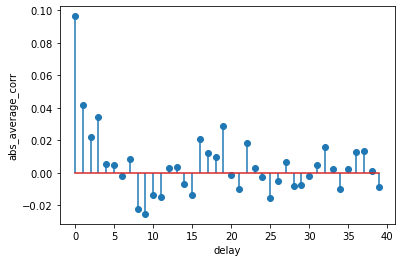

In [8]:
n = 40
l_corr_list = [0 for i in range(n)]
name_list = ['601988.SH']
name_list = new_df.columns[:]
name_list = bestname

for name in tqdm(name_list):
    small_df = df[df['id']==name].copy()
    feature = feature_cal(small_df)
    for i in range(1, n+1):
        l_corr_list[i-1] += (pearsonr(feature, small_df['return_percent'].shift(-i).fillna(0))[0])/len(name_list)

plt.stem(range(n), np.array(l_corr_list))
plt.xlabel('delay')
plt.ylabel('abs_average_corr')
plt.show()

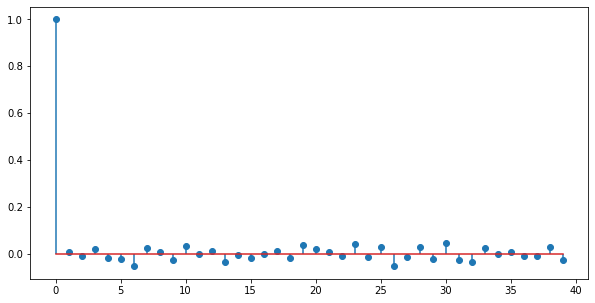

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

series = pd.Series(df_sh300['return_percent'])

autocorrelation = series.autocorr()

# 计算不同滞后阶数的自相关系数
lags = range(40)
autocorrelations = [series.autocorr(lag) for lag in lags]

plt.figure(figsize=(10, 5))
plt.stem(lags, autocorrelations)
plt.show()

# 和vol之间的联系

In [10]:
new_df = df.pivot(index='date', columns='id', values='return_percent').fillna(0)

In [11]:
def feature_cal(df):
    #return ((df['vwap']+df['vwap'])-(df['high']+df['low']))/df['close'].fillna(0)
    # return (df['volume']).diff().fillna(0)
    # return df['return_percent'].rolling(10).std().fillna(0)
    return df['return_percent']

In [12]:
length = 10

df['vol_30'] = df.groupby('id')['return_percent'].rolling(length).std().shift(-length).values
df['vol'] = df['vol_30']**2

#df['vol'] = df['return_percent']**2

In [13]:
s = 0
bestname = []
for name in tqdm(new_df.columns[:]):
    small_df = df[df['id']==name].copy().dropna()
    feature = np.abs(feature_cal(small_df))
    corr = pearsonr(feature[:-1], small_df['vol'].shift(-1)[:-1])
    if (corr[1]) < 0.05:
        bestname.append(name)
    
len(bestname)

100%|██████████| 300/300 [00:07<00:00, 41.97it/s]


277

In [14]:
n = 200
l_corr_list = [0 for i in range(n)]
l_corr_list_ = [0 for i in range(n)]
#bestname = new_df.columns
test_names = bestname[:]

for name in tqdm(test_names):
    small_df = df[df['id']==name].copy().dropna()
    feature = np.abs(feature_cal(small_df))
    for i in range(1, n+1):
        try:
            pear = pearsonr(feature[:-i:3], small_df['vol'].shift(-i)[:-i:3])
        except ValueError:
            pear = (0, 1)
        l_corr_list[i-1] += (pear[0]*(pear[1]<0.05))/len(test_names)
        l_corr_list_[i-1] += (pear[0])/len(test_names)


  0%|          | 0/277 [00:00<?, ?it/s]

100%|██████████| 277/277 [00:21<00:00, 12.70it/s]


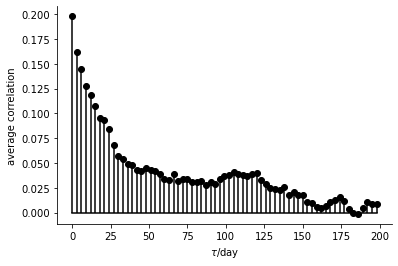

In [15]:
step = 3
plt.stem(range(0,n,step), np.array(l_corr_list[::step]), linefmt='black', markerfmt='ko', basefmt='k-')
ax = plt.gca()

# 隐藏右边和上边的边框
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
#plt.scatter(range(n), np.array(l_corr_list_),c='r')
plt.xlabel(r'$ \tau$/day')
plt.ylabel('average correlation')
#plt.title(r'relation between corr and $\tau$')
plt.show()

# 股票corr

In [17]:
new_df_vol = df.pivot(index='date', columns='id', values='vol').fillna(0)
new_df_resi = new_df.copy()
aver =  np.array(new_df_vol.T.mean()).reshape(-1,1)
for name in new_df_vol.columns:
    fit_y = new_df_vol[name]
    fit_x = aver
    regression_model = LinearRegression()
    regression_model.fit(fit_x, fit_y)

    # 计算拟合后的残差
    residuals = fit_y# - regression_model.predict(fit_x)
    new_df_resi[name] = residuals

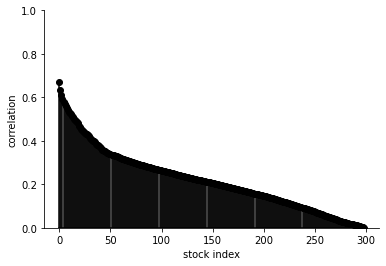

0.2192817148829374


In [18]:
stocks = new_df_resi.columns
corr_list_ = [0 for i in stocks]
for i in range(len(stocks)):
    corr_list = [abs(pearsonr(new_df_resi[stocks[i]],new_df_resi[stocks[j]])[0]) for j in range(len(stocks))]
    (corr_list).sort(reverse= True)
    for j in range(len(stocks)):
        corr_list_[j] += corr_list[j]/len(stocks)
plt.stem(range(len(stocks)-1), corr_list_[1:], linefmt='black', markerfmt='ko', basefmt='k-')
ax = plt.gca()

# 隐藏右边和上边的边框
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xlabel('stock index')
plt.ylabel('correlation')
plt.ylim(0,1)
plt.show()
print(sum(corr_list_[1:])/(len(corr_list_)-1))

# 沪深300

In [19]:
df_sh300.head()

,id,name,open,close,high,low,return,return_percent,pre_close
date,,,,,,,,,
2018-11-12,000300.SH,沪深300,3160.246,3205.1407,3206.512,3152.439,37.6965,1.1901,3167.4442
2018-11-13,000300.SH,沪深300,3164.922,3237.3823,3254.768,3161.097,32.2416,1.0059,3205.1407
2018-11-14,000300.SH,沪深300,3233.640,3204.9427,3239.244,3200.228,-32.4396,-1.0020,3237.3823
2018-11-15,000300.SH,沪深300,3201.281,3242.3715,3242.383,3198.781,37.4288,1.1678,3204.9427
2018-11-16,000300.SH,沪深300,3242.879,3257.6735,3282.390,3223.721,15.3020,0.4719,3242.3715


Text(0, 0.5, 'volatility')

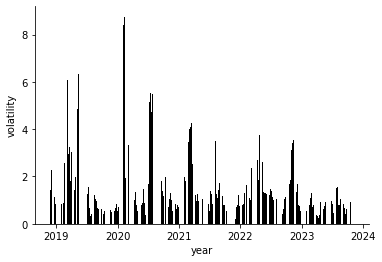

In [20]:
plt.bar(pd.to_datetime(df_sh300.index)[::], (df_sh300['return_percent']**2).rolling(10).mean()[::], color='black')
ax = plt.gca()

# 隐藏右边和上边的边框
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xlabel('year')
plt.ylabel(r'volatility')

# 自相关性

  0%|          | 0/277 [00:00<?, ?it/s]

100%|██████████| 277/277 [00:20<00:00, 13.82it/s]


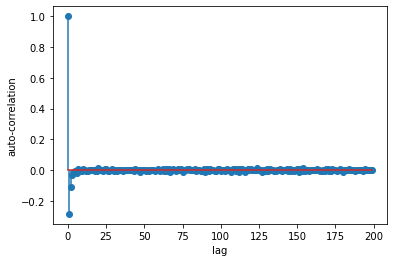

In [21]:
n = 200
l_corr_list = [0 for i in range(n)]
l_corr_list_ = [0 for i in range(n)]
#bestname = new_df.columns
test_names = bestname[:]

for name in tqdm(test_names):
    small_df = df[df['id']==name].copy().dropna()
    series = pd.Series((small_df['volume'].diff()).fillna(0))

    autocorrelation = series.autocorr()

    # 计算不同滞后阶数的自相关系数
    lags = range(n)
    for lag in lags:
        l_corr_list[lag] += series.autocorr(lag)/len(test_names)

plt.stem(range(n), np.array(l_corr_list))
#plt.scatter(range(n), np.array(l_corr_list_),c='r')
plt.xlabel(r'lag')
plt.ylabel('auto-correlation')
#plt.title(r'auto')
plt.show()

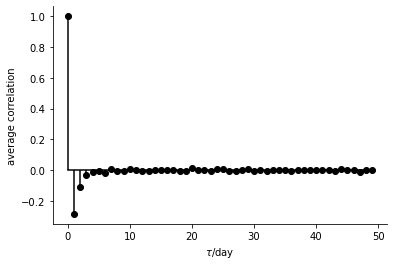

In [22]:
step = 1
plt.stem(range(0,50,step), np.array(l_corr_list[:50:step]), linefmt='black', markerfmt='ko', basefmt='k-')
ax = plt.gca()

# 隐藏右边和上边的边框
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
#plt.scatter(range(n), np.array(l_corr_list_),c='r')
plt.xlabel(r'$ \tau$/day')
plt.ylabel('average correlation')
#plt.title(r'relation between corr and $\tau$')
plt.show()